In [1]:
import numpy as np

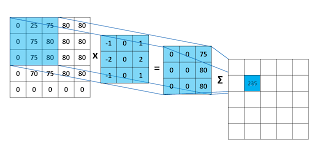

In [2]:

class Conv3x3:
    # A Convolution layer using 3x3 filters.
    
    def __init__(self, num_filters):
        self.num_filters = num_filters

        # filters is a 3d array with dimensions (num_filters, 3, 3)
        # We divide by 9 to reduce the variance of our initial values
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def iterate_regions(self, image):
        '''
        Generates all possible 3x3 image regions using valid padding.
        - image is a 2d numpy array
        '''
        h, w = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the conv layer using the given input.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        - input is a 2d numpy ar
        ray
        '''
        self.last_input = input
        h, w = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output
      
    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
        self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
        return None

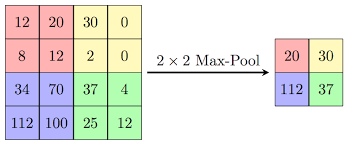


  Max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map

In [3]:

class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

    def iterate_regions(self, image):
        '''
        Generates non-overlapping 2x2 image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output
  
    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

        for i2 in range(h):
            for j2 in range(w):
                for f2 in range(f):
                # If this pixel was the max value, copy the gradient to it.
                    if im_region[i2, j2, f2] == amax[f2]:
                        d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

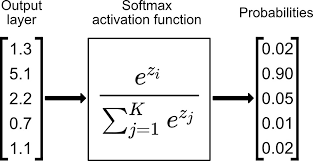


The softmax function, also known as softargmax or normalized exponential function, is a generalization of the logistic function to multiple dimensions.

In [4]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
        Performs a forward pass of the softmax layer using the given input.
        Returns a 1d numpy array containing the respective probability values.
        - input can be any array with any dimensions.
        '''
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)
    
    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
    # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

      # e^totals
            t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
            S = np.sum(t_exp)

      # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

      # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape)

In [5]:
#Extract and prepare MNIST training data
def LoadMNISTSets(fileimage, n):
    fimg = open(fileimage, "rb")

    fimg.read(16) # Read 16 bytes
    number_of_pix = 28*28 # image pixel
    s = (n,number_of_pix)
    image_sets = np.zeros(s)

    for i in range(n):
        for j in range(number_of_pix):
            pix = ord(fimg.read(1))
            image_sets[i,j] = pix

    fimg.close()
    return image_sets

In [6]:
#Extract and prepare MNIST test data
def LoadMNISTLabel(filelabel, n):
    flabel = open(filelabel, "rb")

    flabel.read(8) # Read 8 bytes
    s = (n,10)
    label_sets = np.zeros(s, dtype=int)

    for i in range(n):
        label = ord(flabel.read(1))
        label_sets[i,label] = 1

    flabel.close()
    return label_sets

In [7]:
#Define number of training data
n_training = 60000
#Load training sets
x = LoadMNISTSets("train-images.idx3-ubyte", n_training)
y = LoadMNISTLabel("train-labels.idx1-ubyte", n_training)

In [8]:
# split data set into training and testing
train_images=x[:1000]
train_labels=y[:1000]
test_images=x[1000:2000]
test_labels=y[1000:2000]

In [9]:
train_label=[]
test_label=[]
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        if test_labels[i][j]==1:
            test_label.append(j)
            break
for i in range(len(train_labels)):
    for j in range(len(train_labels[i])):
        if train_labels[i][j]==1:
            train_label.append(j)
            break
            
train_label[101],test_label[100]

(7, 6)

In [10]:
conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
    '''
    Completes a forward pass of the CNN and calculates the accuracy and
    cross-entropy loss.
    - image is a 2d numpy array
    - label is a digit
    '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.005):
    '''
    Completes a full training step on the given image and label.
    Returns the cross-entropy loss and accuracy.
    - image is a 2d numpy array
    - label is a digit
    - lr is the learning rate
    '''
  # Forward
    out, loss, acc = forward(im, label)

  # Calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

  # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc

print('MNIST CNN initialized!')


# Train the CNN for 3 epochs
for epoch in range(3):
    print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
    train_label = np.array(train_label)
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_label = train_label[permutation]

    # Train!
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_label)):
        im=np.reshape(im, (-1, 28))
        if i % 100 == 99:
            print(
            '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
            (i + 1, loss / 100, num_correct)
            )
            loss = 0
        num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_label):
    im=np.reshape(im, (-1, 28))
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.211 | Accuracy: 0%
[Step 200] Past 100 steps: Average Loss 2.062 | Accuracy: 0%
[Step 300] Past 100 steps: Average Loss 1.887 | Accuracy: 0%
[Step 400] Past 100 steps: Average Loss 1.864 | Accuracy: 1%
[Step 500] Past 100 steps: Average Loss 1.815 | Accuracy: 1%
[Step 600] Past 100 steps: Average Loss 1.620 | Accuracy: 1%
[Step 700] Past 100 steps: Average Loss 1.547 | Accuracy: 0%
[Step 800] Past 100 steps: Average Loss 1.471 | Accuracy: 1%
[Step 900] Past 100 steps: Average Loss 1.422 | Accuracy: 1%
[Step 1000] Past 100 steps: Average Loss 1.339 | Accuracy: 1%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 1.145 | Accuracy: 1%
[Step 200] Past 100 steps: Average Loss 1.202 | Accuracy: 1%
[Step 300] Past 100 steps: Average Loss 1.275 | Accuracy: 1%
[Step 400] Past 100 steps: Average Loss 1.225 | Accuracy: 1%
[Step 500] Past 100 steps: Average Loss 1.119 | Accuracy: 1%
[Step 600] Past 100 steps: Av